In [2]:
from google.colab import drive
drive.mount('cookbook')

Drive already mounted at cookbook; to attempt to forcibly remount, call drive.mount("cookbook", force_remount=True).


In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [4]:
# 우선, MNIST dataset에 적용할 transformation 객체를 생성합니다.
from torchvision import transforms

# transformation 정의하기
data_transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
])

In [5]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [6]:
# MNIST training dataset 불러오기
from torchvision import datasets

# 데이터를 저장할 경로 설정
path2data = '/content/data'

# training data 불러오기
train_data = datasets.MNIST(path2data, train=True, download=True, transform=data_transform)

# MNIST test dataset 불러오기
val_data = datasets.MNIST(path2data, train=False, download=True, transform=data_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



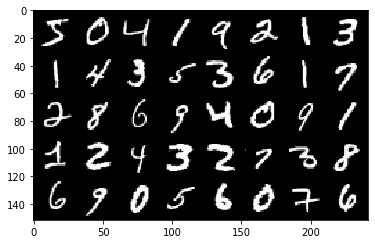

In [7]:
# sample images를 확인합니다.
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training data를 추출합니다.
x_train, y_train = train_data.data, train_data.targets

# val data를 추출합니다.
x_val, y_val = val_data.data, val_data.targets

# 차원을 추가하여 B*C*H*W 가 되도록 합니다.
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)

# tensor를 image로 변경하는 함수를 정의합니다.
def show(img):
    # tensor를 numpy array로 변경합니다.
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경합니다.
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력합니다.
# 총 40개 이미지, 행당 8개 이미지를 출력합니다.
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2)

show(x_grid)

In [8]:
# data loader 를 생성합니다.
from torch.utils.data import DataLoader

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

In [9]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = LeNet_5()
print(model)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
# 모델을 CUDA로 전달합니다.
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [11]:
# 모델 summary를 확인합니다.
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [12]:
# loss function 정의합니다.
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [13]:
# optimizer 정의합니다.
from torch import optim
opt = optim.Adam(model.parameters(), lr=0.001)

# 현재 lr을 계산하는 함수를 정의합니다.
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
# 러닝레이트 스케쥴러를 정의합니다.
from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)

In [14]:
# 배치당 performance metric 을 계산하는 함수 정의
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [15]:
# 배치당 loss를 계산하는 함수를 정의
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [16]:
# epoch당 loss와 performance metric을 계산하는 함수 정의
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True: # sanity_check가 True이면 1epoch만 학습합니다.
            break

    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

In [17]:
# train_val 함수 정의
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }

    # best model parameter를 저장합니다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')

        lr_scheduler.step()

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    # best model을 반환합니다.
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [18]:
import copy
import os

# 학습된 모델의 가중치를 저장할 폴더를 만듭니다.
os.makedirs('/models', exist_ok=True)

# 하이퍼 파라미터를 설정합니다.
params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "/models/LeNet-5.pt",
}

In [19]:
# 모델을 학습합니다.
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/2, current lr=0.001


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Copied best model weights
train loss: 1.563984, dev loss: 1.507563, accuracy: 95.71
----------
Epoch 1/2, current lr=0.000505
Copied best model weights
train loss: 1.494101, dev loss: 1.488702, accuracy: 97.51
----------
Epoch 2/2, current lr=1e-05
Copied best model weights
train loss: 1.484444, dev loss: 1.485315, accuracy: 97.79
----------


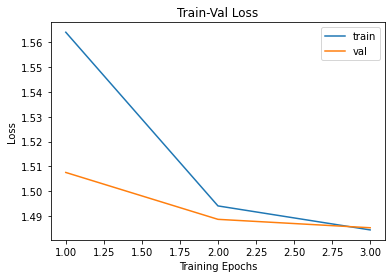

In [20]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

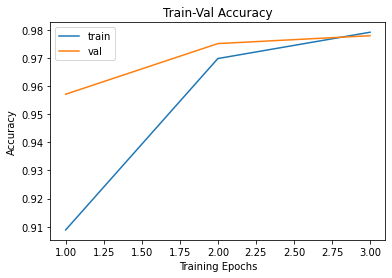

In [21]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()